In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 


In [3]:
def filter_data(data_sent):
    data = data_sent.copy()
    max_flux = -12
    min_flux = 26
    data = data[data['flux_aper']<max_flux]

    data = data[data['significance']>2]
    data_class = data[['class']]

    data_sig = data['significance']
    data_id = data['src_id']
    data_name = data['src_n']
    obs_info_params = [ 'livetime','likelihood','pileup_flag','mstr_sat_src_flag','mstr_streak_src_flag'   ,'gti_obs' , 'flux_significance_b'  , 'flux_significance_m' , 'flux_significance_s' , 'flux_significance_h' , 'flux_significance_u'    ]
    data_val = data.drop(columns=obs_info_params).reset_index(drop=True)
    return data_val


In [38]:

def extract_data(data_sent , impute_fn,reduce_fn):
    data = data_sent.copy()
    data = data.sample(frac=1)
    data = filter_data(data)
    #display(data)
    data_id = data[['class' ,'src_n' , 'src_id' ,'significance']]
    data_id = data_id.reset_index(drop=True)
    data_val = data.drop(['index' , 'class' ,'src_n' , 'src_id' ,'significance'] , axis=1).reset_index(drop=True)
    data_val = reduce_fn(data_val)
    data_val = impute_fn(data_val)
    #return data_val
    data_val = data_val.reset_index(drop=True)
    data_reduced = pd.concat([data_id , data_val] , axis=1)
    return(data_reduced)

def no_impute(data_sent):
    return data_sent

def median_impute(data_send):
    data = data_send.copy()
    for d in data:
        data.fillna((data[d].median()), inplace=True)
    return data

def mean_impute(data_sent):
    data = data_sent.copy()
    for d in data:
        #mean = np.mean(data[d])
        data.fillna((data[d].mean()), inplace=True)
    return data 



def zero_impute(data_sent):
    data= data_sent.copy()
    data = data.replace(np.nan , 0)
    return data

def norm_data(data_sent):
    data = data_sent.copy()
    #data.replace()
    for d in data:
        max_val = np.amax(data[d])
        min_val =  np.amin(data[d])
        data[d] = (data[d]-min_val)/(max_val-min_val)
    return data


def do_nothing(data_sent):
    return data_sent

def std_data(data_sent):
    data = data_sent.copy()
    for d in data:
        mean =  np.mean(data[d])
        std = np.sqrt(np.var(data[d]))
        data[d] = (data[d]-mean)/std 
    return data


In [39]:

train_bh = pd.read_csv('processed_data/BH_.csv')
train_bh = train_bh.sample(frac=1)

train_ns = pd.read_csv('processed_data/NS_.csv')
train_ns = train_ns.sample(frac=1)

train = pd.concat([train_bh , train_ns ] , axis=0)
train =  train.sample(frac=1)


## Correlation imputation scheme

In [25]:
from tqdm import tqdm 

In [40]:
def corr_impute(data_sent):
    '''
    calculate fearure correlation with each other
    for every sample , for each feature 
    '''
    corr_mat = data_sent.corr().values
    slope_mat , int_mat = linear_reg(data_sent)
    #return 
    data = data_sent.copy()
    r , c = data_sent.shape
    for ri in (range(r)):
        for ci in (range(c)):
            if(np.isnan(data.iloc[ri , ci])): 
                temp = np.abs(corr_mat[ci])
                temp[ci] = 0 
                corr_index = np.argsort(temp)[::-1]
                for cm in corr_index:
                    xi = data.iloc[ri , cm]
                    if(np.isnan(xi)): 
                        print(ri , ci , cm , 'going to next corr')
                        continue
                    else : 
                        val = xi*slope_mat[ci , cm] + int_mat[ci , cm]
                        data.iloc[ri , ci] = val
                        break
    print(data.shape)
    return data
from scipy.stats import linregress
def linear_reg(data_sent):
    
    data = data_sent.copy()
    rows = data.columns
    c = data_sent.shape[1]
    slope_mat =  np.zeros(shape=(c,c))
    int_mat = np.zeros(shape= (c,c))
    for ri in range(len(rows)):
        for ci in range(len(rows)):
            data_now = data[[rows[ri] , rows[ci]]]
            data_now = data_now.dropna(axis=0,how='any').values
            x  , y = data_now[:,0] , data_now[:,1]
            reg = linregress(data_now)
            slope_mat[ri ,ci] = reg.slope
            int_mat[ri,ci] = reg.intercept

    slope_mat = np.asmatrix(slope_mat)
    int_mat = np.asmatrix(int_mat)
    print(slope_mat[:10, :10])
    print(int_mat[:10, :10])
    return slope_mat , int_mat
#print(type(train.iloc[1,2]))
#display(train.iloc[])


In [41]:
train_data = extract_data(train , corr_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.head())

[[1.         0.48830433 0.77076353 0.50288367 0.6156728  0.96179021
  0.41180594 0.75821139 0.40376858 0.56006084]
 [0.55097621 1.         0.4238594  0.51779134 0.47459605 0.46751035
  1.12014374 0.33370366 0.28543721 0.30953251]
 [0.91999337 0.4583204  1.         0.73729362 0.8274013  0.77476592
  0.31984995 1.0455034  0.67409682 0.77766833]
 [0.55770661 0.51129842 0.67870855 1.         0.92047467 0.56917108
  0.42783345 0.65240308 1.07007512 0.82641776]
 [0.71840908 0.49310348 0.78316774 0.97334774 1.         0.72623308
  0.45274353 0.82879844 1.08411276 1.00228233]
 [0.90242502 0.47195688 0.80533203 0.66851728 0.79668913 1.
  0.58505069 0.81499608 0.62632989 0.75696213]
 [0.54318952 0.74623758 0.43268497 0.54551973 0.57512131 0.6264544
  1.         0.53643523 0.579333   0.53804015]
 [0.8239531  0.31801196 0.85041434 0.68181646 0.76164684 0.72260323
  0.31902073 1.         0.68187895 0.74788484]
 [0.4935917  0.25960746 0.59544891 0.81154154 0.76258145 0.50549311
  0.38754563 0.619820

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
index,,,,,,,,,,,,,,,,,,,,,
0,NS,XTE J1709-267,NS0049,212.84,0.689656,0.766983,0.661633,0.566927,0.653287,0.738682,...,0.026071,0.019690,0.028658,0.006601,0.025210,0.006006,0.015353,0.018974,0.009679,0.135266
1,NS,2E 1613.5-5053,NS0009,107.71,0.799780,0.987478,0.953386,0.933733,0.960728,0.788720,...,0.744122,0.677057,0.771532,0.006882,0.021393,0.007688,0.127853,0.122623,0.121686,0.077510
2,NS,KS 1731-260,NS0033,14.81,0.538866,0.128335,0.665694,0.562747,0.625426,0.607935,...,0.016483,0.009810,0.019130,0.002695,0.009954,0.002437,0.082201,0.083298,0.074654,0.015363
3,BH,J1745-2900,BH0027,337.00,0.082300,0.334773,0.229398,0.569841,0.563781,0.104077,...,0.050408,0.055467,0.047807,1.029149,0.127116,1.477203,1.111106,1.043694,1.209083,0.622087
4,NS,KS 1731-260,NS0033,14.81,0.363420,0.069440,0.479959,0.278294,0.404859,0.431264,...,0.041586,0.046402,0.039063,0.371352,0.053466,0.493718,0.977528,0.918137,1.064057,0.713443


In [28]:
import seaborn as sns 

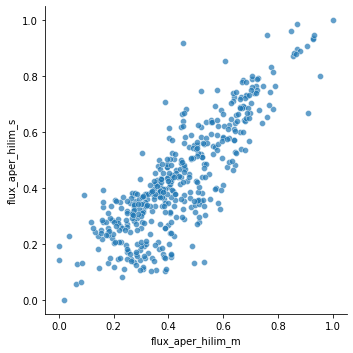

In [43]:

sns.relplot(
    data =  train_data ,
    x = 'flux_aper_hilim_m' , 
    y = 'flux_aper_hilim_s' , 
    kind='scatter' ,
    alpha=0.7
)
plt.show()

In [46]:
train_data = extract_data(train , median_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.head())

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
index,,,,,,,,,,,,,,,,,,,,,
0,BH,IGR J17464-3213,BH0008,6.90,0.138562,0.159902,0.346805,0.483656,0.475751,0.391946,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
1,NS,XMMU J004245.2+41172,NS0044,49.26,0.553830,0.391946,0.493603,0.469506,0.525433,0.624346,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
2,NS,XMMU J004245.2+41172,NS0044,49.26,0.637577,0.675340,0.559431,0.585513,0.612737,0.591779,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
3,NS,XMMU J004245.2+41172,NS0044,49.26,0.561583,0.758723,0.526456,0.497736,0.483129,0.391946,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
4,BH,J1242+3232,BH0025,2.26,0.294773,0.232054,0.186691,0.194543,0.149622,0.365813,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946


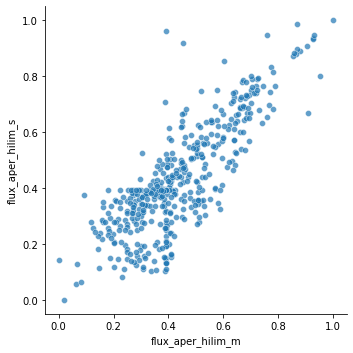

In [47]:

sns.relplot(
    data =  train_data ,
    x = 'flux_aper_hilim_m' , 
    y = 'flux_aper_hilim_s' , 
    kind='scatter' ,
    alpha=0.7
)
plt.show()

In [48]:
train_data = extract_data(train , median_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.describe())
train_data.to_csv('processed_data/train_norm_median_impute')

train_data = extract_data(train , mean_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.describe())
train_data.to_csv('processed_data/train_norm_mean_impute')

train_data = extract_data(train , zero_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.describe())
train_data.to_csv('processed_data/train_norm_zero_impute')

train_data = extract_data(train , no_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.describe())
train_data.to_csv('processed_data/train_norm_no_impute')

train_data = extract_data(train , corr_impute , norm_data).reset_index(drop=True)
train_data.index.name = 'index'
display(train_data.describe())
train_data.to_csv('processed_data/train_norm_corr_impute')

,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.432186,0.399933,0.436436,0.486806,0.502991,0.471289,0.399244,0.456698,0.482287,...,0.366822,0.365752,0.367300,0.354110,0.361636,0.349912,0.354869,0.355594,0.356215,0.355732
std,109.946267,0.193170,0.166272,0.173786,0.185332,0.185008,0.169059,0.085081,0.167799,0.173541,...,0.111591,0.111370,0.111445,0.128678,0.106576,0.122419,0.120236,0.121704,0.116295,0.108540
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.309677,0.297512,0.313406,0.358979,0.368118,0.391946,0.391946,0.391382,0.391946,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
50%,23.470000,0.391946,0.391946,0.402127,0.502370,0.504328,0.391946,0.391946,0.391946,0.437503,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.391946,0.552846,0.599765,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.435094,0.411001,0.439062,0.488025,0.503648,0.486766,0.435076,0.469924,0.491760,...,0.404623,0.403553,0.405101,0.391912,0.399813,0.387714,0.392670,0.393395,0.394298,0.393533
std,109.946267,0.192867,0.166808,0.173418,0.184844,0.184688,0.162938,0.083531,0.163819,0.169472,...,0.120659,0.120791,0.120374,0.140097,0.117762,0.135550,0.132169,0.133299,0.128239,0.121356
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.309677,0.297512,0.313406,0.358979,0.368118,0.435094,0.435094,0.391382,0.416628,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
50%,23.470000,0.414513,0.435094,0.419350,0.502370,0.504328,0.435094,0.435094,0.435094,0.437503,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.435094,0.552846,0.599765,...,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094,0.435094
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.405772,0.299390,0.412578,0.475729,0.497027,0.330700,0.073759,0.336558,0.396229,...,0.023443,0.022373,0.023921,0.010732,0.014849,0.006533,0.011490,0.012215,0.010280,0.012353
std,109.946267,0.221633,0.242112,0.202805,0.201697,0.194583,0.293861,0.183519,0.276541,0.268479,...,0.108967,0.105301,0.110320,0.085034,0.077365,0.052629,0.075177,0.080658,0.068562,0.059748
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.270218,0.000000,0.286216,0.324350,0.358846,0.000000,0.000000,0.000000,0.175331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.470000,0.381014,0.295346,0.402127,0.502370,0.504328,0.363721,0.000000,0.360282,0.437503,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.260000,0.555333,0.531809,0.533815,0.615238,0.626640,0.549342,0.000000,0.552846,0.599765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,429.000000,342.000000,432.000000,447.000000,453.000000,295.000000,78.000000,319.000000,359.000000,...,57.000000,57.000000,57.000000,57.000000,53.000000,57.000000,57.000000,57.000000,54.000000,57.000000
mean,70.680500,0.435094,0.402689,0.439319,0.489565,0.504707,0.515667,0.434988,0.485319,0.507703,...,0.189189,0.180554,0.193049,0.086606,0.128881,0.052726,0.092727,0.098580,0.087569,0.099692
std,109.946267,0.199729,0.192830,0.178960,0.187294,0.185914,0.197767,0.203943,0.194834,0.188846,...,0.255747,0.248626,0.257919,0.229300,0.194559,0.142209,0.196609,0.211325,0.183887,0.142819
min,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.294773,0.231368,0.307207,0.351314,0.366169,0.384478,0.299916,0.343379,0.373355,...,0.036211,0.029144,0.039309,0.004473,0.013922,0.004971,0.009932,0.014095,0.014085,0.048054
50%,23.470000,0.391946,0.396486,0.408714,0.508516,0.506154,0.483627,0.443376,0.466397,0.515729,...,0.059665,0.056840,0.060551,0.020767,0.064800,0.020885,0.026950,0.025612,0.026496,0.071503
75%,49.260000,0.569852,0.572477,0.554868,0.618260,0.629241,0.659338,0.576804,0.638826,0.630503,...,0.225896,0.210331,0.232454,0.041313,0.135214,0.039631,0.043906,0.050849,0.041475,0.113665
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[[1.         0.48830433 0.77076353 0.50288367 0.6156728  0.96179021
  0.41180594 0.75821139 0.40376858 0.56006084]
 [0.55097621 1.         0.4238594  0.51779134 0.47459605 0.46751035
  1.12014374 0.33370366 0.28543721 0.30953251]
 [0.91999337 0.4583204  1.         0.73729362 0.8274013  0.77476592
  0.31984995 1.0455034  0.67409682 0.77766833]
 [0.55770661 0.51129842 0.67870855 1.         0.92047467 0.56917108
  0.42783345 0.65240308 1.07007512 0.82641776]
 [0.71840908 0.49310348 0.78316774 0.97334774 1.         0.72623308
  0.45274353 0.82879844 1.08411276 1.00228233]
 [0.90242502 0.47195688 0.80533203 0.66851728 0.79668913 1.
  0.58505069 0.81499608 0.62632989 0.75696213]
 [0.54318952 0.74623758 0.43268497 0.54551973 0.57512131 0.6264544
  1.         0.53643523 0.579333   0.53804015]
 [0.8239531  0.31801196 0.85041434 0.68181646 0.76164684 0.72260323
  0.31902073 1.         0.68187895 0.74788484]
 [0.4935917  0.25960746 0.59544891 0.81154154 0.76258145 0.50549311
  0.38754563 0.619820

,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,0.428578,0.420357,0.433920,0.481062,0.504533,0.436517,0.434097,0.435983,0.465390,...,0.251453,0.259866,0.248030,0.612394,0.093594,0.852212,0.732214,0.689055,0.795208,0.659974
std,109.946267,0.198401,0.200715,0.182517,0.192136,0.185377,0.208229,0.164964,0.193531,0.195705,...,0.284852,0.291700,0.282629,0.284747,0.070030,0.415186,0.298392,0.279563,0.326928,0.229451
min,2.110000,0.000000,0.000000,-0.000767,0.000000,0.000000,-0.082395,0.000000,-0.029526,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,0.286660,0.243411,0.302125,0.326932,0.365424,0.293230,0.298375,0.300438,0.304614,...,0.040732,0.045360,0.038345,0.452352,0.069422,0.608091,0.658813,0.618561,0.717195,0.654979
50%,23.470000,0.390999,0.430555,0.407365,0.502370,0.505772,0.426510,0.441569,0.409963,0.466873,...,0.052287,0.056642,0.050388,0.655933,0.090041,0.916857,0.758004,0.712205,0.825719,0.711883
75%,49.260000,0.561875,0.589274,0.553205,0.615238,0.627824,0.558226,0.569438,0.559324,0.600996,...,0.550404,0.569200,0.543390,0.814252,0.107216,1.151447,0.940119,0.882975,1.018479,0.785485
max,376.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.085012,1.000000,1.560725,1.111106,1.043694,1.209083,1.000000


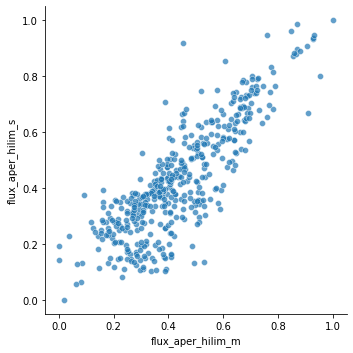

In [49]:

sns.relplot(
    data =  train_data ,
    x = 'flux_aper_hilim_m' , 
    y = 'flux_aper_hilim_s' , 
    kind='scatter' ,
    alpha=0.7
)
plt.show()